# Statistics

In [ ]:
%load_ext autoreload
%autoreload 2

In [122]:
from glob import glob 
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

sns.set('notebook', 'white')

df_all_ = None
for result_file in glob('data/results/*.npy'):
    print(result_file)
    with open(result_file, 'rb') as f:
        result = pickle.load(f)
    dataset = result_file.split('/')[-1].rsplit('.', 2)[0]
    is_graph_dataset = 'graph' in dataset
    is_cooccurrence_dataset = 'cooccurrence' in dataset
    dataset_name = dataset
    if is_graph_dataset:
        result['relabeled'] = 'relabeled' in result_file
        result['wl_iteration'] = int(dataset.split('.')[-1])
        parts = dataset.split('_')
        if is_cooccurrence_dataset:
            dataset_name = parts[-1].split('_')[0].split('.')[0]
            result['words'] = parts[4]
            result['window_size'] = parts[3]
        # GML
        else:
            dataset_name = parts[3].split('.')[0]
            result['words'] = 'concepts'
        result['type'] = 'cooccurrence' if is_cooccurrence_dataset else 'concept-graph'
    else:
        result['type'] = 'text'
        dataset_name = dataset.split('_')[1]
        result['words'] = ['all' if x['preprocessing'] != None else 'only-nouns'  for x in result['params']]
        #result['words'] = result['params']['preprocessing']
    result['classifier'] = [None] * len(result['params'])
    for idx, param in enumerate(result['params']):
        is_dummy = isinstance(param['clf'], sklearn.dummy.DummyClassifier)
        result['classifier'][idx] = type(param['clf']).__name__
        del param['clf']
    if dataset_name.endswith('-single'):
        dataset_name = dataset_name.rsplit('-', 1)[0]
    del result['param_clf']
    result['dataset'] = dataset_name
    result_df = pd.DataFrame(result).sort_values(by = 'dataset', ascending = False)
    if df_all_ is None:
        df_all_ = result_df
    else:
        df_all_ = df_all_.append(result_df)
#df_all['window_size'].fillna('concept-graph', inplace = True)

data/results/dataset_graph_cooccurrence_1_all_ling-spam.phi.npy.0.results.npy
data/results/dataset_graph_cooccurrence_1_all_ling-spam.phi.npy.1.results.npy
data/results/dataset_graph_cooccurrence_1_all_ling-spam.phi.npy.2.results.npy
data/results/dataset_graph_cooccurrence_1_all_ling-spam.phi.npy.3.results.npy
data/results/dataset_graph_cooccurrence_1_all_ling-spam.phi.npy.4.results.npy
data/results/dataset_graph_cooccurrence_1_all_ng20.phi.npy.0.results.npy
data/results/dataset_graph_cooccurrence_1_all_ng20.phi.npy.1.results.npy
data/results/dataset_graph_cooccurrence_1_all_ng20.phi.npy.2.results.npy
data/results/dataset_graph_cooccurrence_1_all_ng20.phi.npy.3.results.npy
data/results/dataset_graph_cooccurrence_1_all_ng20.phi.npy.4.results.npy
data/results/dataset_graph_cooccurrence_1_all_relabeled_ling-spam.phi.npy.0.results.npy
data/results/dataset_graph_cooccurrence_1_all_relabeled_ling-spam.phi.npy.1.results.npy
data/results/dataset_graph_cooccurrence_1_all_relabeled_ling-spam.phi

data/results/dataset_graph_cooccurrence_2_all_relabeled_webkb.phi.npy.4.results.npy
data/results/dataset_graph_cooccurrence_2_all_reuters-21578.phi.npy.0.results.npy
data/results/dataset_graph_cooccurrence_2_all_reuters-21578.phi.npy.1.results.npy
data/results/dataset_graph_cooccurrence_2_all_reuters-21578.phi.npy.2.results.npy
data/results/dataset_graph_cooccurrence_2_all_reuters-21578.phi.npy.3.results.npy
data/results/dataset_graph_cooccurrence_2_all_reuters-21578.phi.npy.4.results.npy
data/results/dataset_graph_cooccurrence_2_all_webkb.phi.npy.0.results.npy
data/results/dataset_graph_cooccurrence_2_all_webkb.phi.npy.1.results.npy
data/results/dataset_graph_cooccurrence_2_all_webkb.phi.npy.2.results.npy
data/results/dataset_graph_cooccurrence_2_all_webkb.phi.npy.3.results.npy
data/results/dataset_graph_cooccurrence_2_all_webkb.phi.npy.4.results.npy
data/results/dataset_graph_cooccurrence_2_only-nouns_ling-spam.phi.npy.0.results.npy
data/results/dataset_graph_cooccurrence_2_only-noun

data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ling-spam.phi.npy.0.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ling-spam.phi.npy.1.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ling-spam.phi.npy.2.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ling-spam.phi.npy.3.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ling-spam.phi.npy.4.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ng20.phi.npy.0.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ng20.phi.npy.1.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ng20.phi.npy.2.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ng20.phi.npy.3.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_ng20.phi.npy.4.results.npy
data/results/dataset_graph_cooccurrence_3_only-nouns_relabeled_reuters-2157

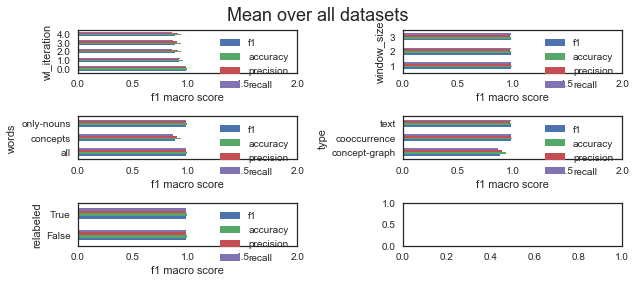

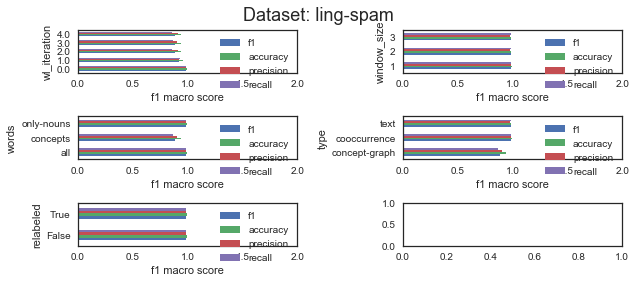

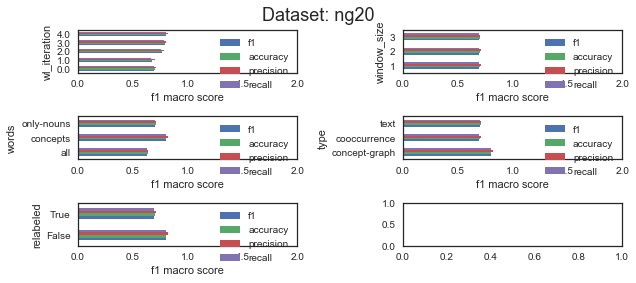

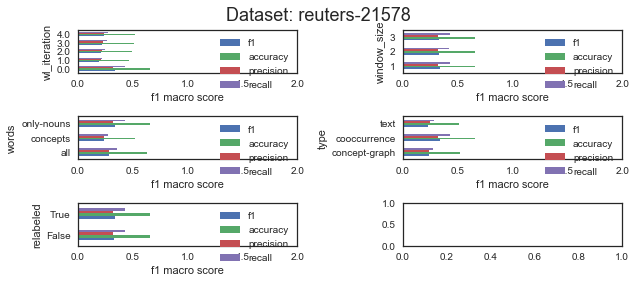

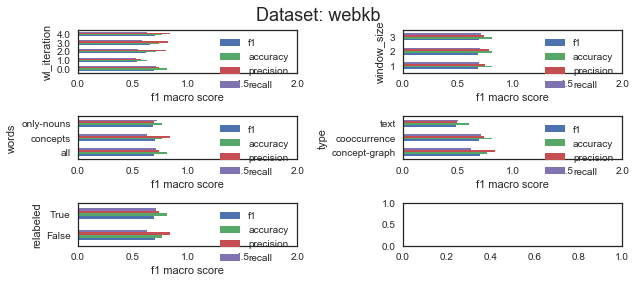

In [123]:
sns.set('notebook', 'white')
def plot_distributions(df, df_all, title = None, figsize = (9, 4)):
    fig, axes_indexed = plt.subplots(nrows = 3, ncols=2, figsize = figsize)

    axes = []
    for ax_row in axes_indexed:
        axes += list(ax_row)
    for val, ax in zip(['wl_iteration', 'window_size', 'words', 'type', 'relabeled'], axes):
        if len(df.groupby(val).size()) == 0:
            continue
        grouped = df.groupby(val)
        els = df_all.iloc[grouped['mean_test_f1_macro'].idxmax()]
        els = els.set_index(val)
        els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
        els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim=(0, 2))
        #df.groupby(val).mean_test_f1_macro.mean().plot(kind = 'barh', ax = ax, xlim = (0, 1))
        ax.set_xlabel('f1 macro score')
    plt.suptitle(title, size = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    return fig, axes
    
dpi = 150
df_all = df_all_.groupby('dataset').filter(lambda x: len(x.type.value_counts()) == 3).reset_index(drop=True)
fig, _  = plot_distributions(df_all, df_all, title = 'Mean over all datasets')
fig.savefig('tmp/results/all.png', dpi = dpi)
plt.show()
plt.close(fig)
for name, df_dataset in df_all.groupby('dataset'):
    if len(df_dataset.type.value_counts()) < 3:
        continue
    fig, _ = plot_distributions(df_dataset, df_all, title = 'Dataset: {}'.format(name))
    fig.savefig('tmp/results/dataset-{}.png'.format(name), dpi = dpi)
    plt.show()
    plt.close(fig)


In [131]:
df_all[df_all.classifier == 'DummyClassifier'].groupby('dataset').mean_test_f1_macro.max()

dataset
ling-spam        0.458485
ng20             0.005613
reuters-21578    0.005194
webkb            0.089303
Name: mean_test_f1_macro, dtype: float64

In [ ]:
def plot_best_by_type(df_all, df, title = '', fontsize = 12, figsize = (6, 3), top = 0.85):
    fig, ax = plt.subplots(figsize = figsize)
    els = df_all.iloc[df['mean_test_f1_macro'].idxmax()]
    els = els.set_index('type')
    els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
    els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim = (0, 1.5))
    #    df['mean_test_f1_macro'].max().plot(kind = 'barh', ax = ax, xlim = (0, 1))#, xerr=els.std_test_f1_macro * 2)
    ax.set_xlabel('f1 score')
    for set_type, x in els.iterrows():
        out = '{:20}best f1-score: {x.f1:.4f}\twords: {x.words:14}'.format(set_type, x = x)
        if set_type != 'text':
            out += 'wl iteration: {x.wl_iteration:<8.0f} relabeled: {x.relabeled:<6}'.format(x = x)
        else:
            out += 'stop words:   {}'.format(x.params["count_vectorizer__stop_words"])
        if set_type == 'cooccurrence':
            out += 'window_size: {x.window_size}'.format(x = x)
        print(out)
    display(els)
    if title and title != '':
        fig.suptitle(title, fontsize = fontsize)
    fig.tight_layout()
    if title and title != '':
        fig.subplots_adjust(top = top)
    return fig, ax

for name, df_dataset in sorted(df_all.groupby('dataset'), key = lambda x: x[0]):
    df_dataset_grouped_by_type = df_dataset.groupby('type')
    print(name)
    use_title = False
    fig, ax = plot_best_by_type(df_all, df_dataset_grouped_by_type, 'Dataset: {}'.format(name) if use_title else None)
    fig.savefig('tmp/results/dataset-{}-best.png'.format(name), dpi = 150)
    plt.show()
    plt.close(fig)


In [ ]:
for name, df_dataset in sorted(df_all.groupby('dataset'), key = lambda x: x[0]):
    plt.show()

In [ ]:
df_by_ds = df_all[df_all.type != 'text'].groupby('dataset')

df_all.iloc[df_by_ds.mean_test_score.idxmax()]
df_all.columns

In [ ]:
import json

with open('data/check-w2v-results.json') as f:
    w2v_results = json.load(f)
 
per_embedding_type = {}
for dataset, value in w2v_results.items():
    print(dataset)
    for embedding_raw, cache_files in sorted(value.items(), key = lambda x: x[0]):
        embedding = embedding_raw.split('/')[-1].rsplit('.', 2)[0]
        if len(cache_files.keys()) != 2: continue
        print('\t{}'.format(embedding))
        if embedding not in per_embedding_type:
            per_embedding_type[embedding] = {}
        per_embedding_type[embedding][dataset] = []
        for dataset_file, counts in sorted(cache_files.items(), key = lambda x: x[0]):
            not_found_ratio = int(counts['counts']['not_found'] / counts['num_labels'] * 100)
            if embedding == 'trained' and 'coo' in  dataset_file:
                print('Yes', counts['counts']['not_found'], not_found_ratio, '%', counts['not_found_sample'])
            is_gml = 'dataset_graph_gml' in dataset_file
            per_embedding_type[embedding][dataset].append((is_gml, not_found_ratio))
            print('\t\t{:4} missing  {:3>}%'.format('gml' if is_gml else 'co', not_found_ratio))
        per_embedding_type[embedding][dataset] = per_embedding_type[embedding][dataset][0][1]  #sum(y for x, y in per_embedding_type[embedding][dataset]) / 2
df = pd.DataFrame(per_embedding_type)
df#[df.index == "ng20"]

In [ ]:
import dataset_helper
import matplotlib.pyplot as plt

currently = ['ling-spam', 'webkb', 'ng20', 'reuters-21578']

for dataset in dataset_helper.get_all_available_dataset_names():
    if dataset in currently: continue
    print(dataset)
    continue
    X, Y = dataset_helper.get_dataset(dataset)
    dataset_helper.plot_dataset_class_distribution(X, Y, 'Class distribution: {}'.format(dataset))
    plt.show()
    print('{}\n#Docs:\t{}\t# Classes:\t{}'.format(dataset, len(X), len(set(Y))))